<a href="https://colab.research.google.com/github/EliseuODaniel/analise_de_sentimentos_eleicao/blob/main/analise_sentimento_com_bert_Tweets_lula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimento com Bert

## Projeto integrador

## Classificação de Texto

utilização da arquitetura BERTimbau, versão em Português do BERT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 53.8 MB/s 
     |████████████████████████████████| 163 kB 73.5 MB/s 


Lê o arquivo csv e transforma numa lista

In [ ]:
import pandas as pd
import csv
from random import shuffle
import nltk
nltk.download('punkt')

full_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets_lula_cleaned-categorizado.csv', sep=';')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24698 entries, 0 to 24697
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       24698 non-null  int64  
 1   date     24698 non-null  object 
 2   content  24695 non-null  object 
 3   label    408 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 771.9+ KB


In [ ]:
# Drop rows with any empty cells in collumn 'label'
df = full_df.dropna(subset=['label'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 409
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       408 non-null    int64  
 1   date     408 non-null    object 
 2   content  408 non-null    object 
 3   label    408 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.9+ KB


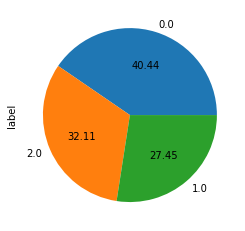

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

#  mostra a proporção de cada label, se não está balanceado, acurácia não é uma boa métrica
df['label'].value_counts().plot.pie(autopct='%.2f')

In [ ]:
# converte dataframe em lista de listas
tweets_list = df.values.tolist()

cria uma lista com dicionarios de reviews e rating

In [ ]:
#print(tweets_list)

In [ ]:
tweets = [str(w[2]) for w in tweets_list]
ratings = [int(w[3]) for w in tweets_list]
data = [{ 'X': tweets, 'y': rating } for (tweets, rating) in zip(tweets, ratings)]

In [ ]:
#print(data)

In [ ]:
#print(type(data))
#print(data)

Separando os dados em conjunto de treino e teste

In [ ]:
size = int(len(data) * 0.1)
treino = data[2*size:] #  0.2 - 1
validacao = data[size:2*size] # 0.1:0.2
teste = data[:size]  # 0:0.1

len(treino), len(validacao), len(teste)

(328, 40, 40)

BERTimbau - documentação [este link](https://github.com/neuralmind-ai/portuguese-bert).

In [ ]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

Instanciando parâmetros

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 3  # número de classes/labels que classificam  os tweets (0 = negativo, 1 = indefinido, 2 = positivo)
nepochs = 5  # número de épocas (valor inicial: 5)
batch_size = 1  # número mínimo de frases que são previstas por vez - em datasets grandes, número pode ser maior
batch_status = 8  # a cada quantas batches avalia o status - numero menor pra dataset menor
learning_rate = 1e-5  # taxa de aprendizado
early_stop = 2  # critério de parada

max_length = 512 # tamanho maximo de cada frase
write_path = 'model'

Separando os dados em batches de treino e teste



In [ ]:
from torch.utils.data import DataLoader

traindata = DataLoader(treino, batch_size=batch_size, shuffle=True)
validationdata = DataLoader(validacao, batch_size=batch_size, shuffle=True)
testdata = DataLoader(teste, batch_size=batch_size, shuffle=True)

instanciando tokenizador, modelo, função de erro e otimizador:

In [ ]:
# instancia o tokenizador
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)  # para utilizar o BERTinbal large: 'neuralmind/bert-large-portuguese-cased'
#bertinbal menor: 'neuralmind/bert-base-portuguese-cased'
#  instancia o modelo
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased', num_labels=nclasses).to(device)

# seleciona o otimizador 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# congela os pesos do BERT pré-treinado
for param in model.base_model.parameters():
    param.requires_grad = False

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

Definindo a função de avaliação do modelo

In [ ]:
def evaluate(model, validationdata):
  """
  avalia o desempenho do modelo que está sendo treinado baseado nos dados de validacao
  """
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(validationdata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']
    
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    
    # cria um tensor com os labels preditos no output
    pred_labels = torch.argmax(output.logits, 1)

    # print(f"texto: {texts}, rótulo correto: {labels}, predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito
    
    # adiciona cada novo label às listas y_real e y_pred(ito)
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    # a cada certa quantidade de itens preditos, printa a % de progresso e o número de itens preditos
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  # chama o classification_report do scikitlearn para calcular o resultado após predizer todas as linhas de teste
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negative', 'Neural', 'Positive'])) # identifica os labels 0, 1 e 2 como negativo, neutro e positivo
  # retorna f1 e acurácia
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [ ]:
max_f1, repeat = 0, 0

#  passa por todas as épocas de treino
for epoch in range(nepochs):
  model.train()
  #avalia o modelo antes de iniciar a 1a época
  f1, acc = evaluate(model, testdata)
  losses = []

  for batch_idx, inp in enumerate(traindata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']

    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # zera os gradientes acumulados em buffer 
    optimizer.zero_grad()
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs, labels=labels.to(device))

    # calcula a perda
    loss = output.loss
    losses.append(float(loss))

    # faz o Backpropagation no modelo- com o otimizador definido anteriormente (AdamW)
    loss.backward()
    optimizer.step()

    # mostra o andamento do treinamento
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(\
        epoch, # número da época
        batch_idx+1, # número do batch
        len(traindata), # número total de dados de treino
        100. * batch_idx / len(traindata), # % de dados treinados
        float(loss), # perda atual
        round(sum(losses) / len(losses), 5) # perda acumulada
        ))

  # se passou a 1a época, descongela os pesos do Bert pretreinado
  if epoch == 0: 
    for param in model.base_model.parameters():
        param.requires_grad = True

  # ao terminar cada época, avalia o modelo
  f1, acc = evaluate(model, testdata)
  print('F1: ', f1, 'Accuracy: ', acc)

  # salva o modelo se f1 melhorou em relação à epoch anterior
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  # se por duas épocas o f1 não melhorou, para de treinar o modelo
  if repeat == early_stop:
    break

Progress: 0.17 7
Progress: 0.38 15
Progress: 0.57 23
Progress: 0.78 31
Progress: 0.97 39
              precision    recall  f1-score   support

    Negative       0.69      0.50      0.58        18
      Neural       0.22      0.75      0.34         8
    Positive       0.00      0.00      0.00        14

    accuracy                           0.38        40
   macro avg       0.30      0.42      0.31        40
weighted avg       0.36      0.38      0.33        40

Train Epoch: 0 [8/328 (2%)]	Loss: 1.069197	Total Loss: 1.170200


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Epoch: 0 [16/328 (5%)]	Loss: 1.060873	Total Loss: 1.132700
Train Epoch: 0 [24/328 (7%)]	Loss: 0.955483	Total Loss: 1.119050
Train Epoch: 0 [32/328 (9%)]	Loss: 1.075424	Total Loss: 1.111860
Train Epoch: 0 [40/328 (12%)]	Loss: 1.156581	Total Loss: 1.103380
Train Epoch: 0 [48/328 (14%)]	Loss: 1.146641	Total Loss: 1.112830
Train Epoch: 0 [56/328 (17%)]	Loss: 0.854305	Total Loss: 1.120530
Train Epoch: 0 [64/328 (19%)]	Loss: 0.998378	Total Loss: 1.105700
Train Epoch: 0 [72/328 (22%)]	Loss: 1.242659	Total Loss: 1.126910
Train Epoch: 0 [80/328 (24%)]	Loss: 1.222402	Total Loss: 1.123900
Train Epoch: 0 [88/328 (27%)]	Loss: 1.108009	Total Loss: 1.112710
Train Epoch: 0 [96/328 (29%)]	Loss: 1.487289	Total Loss: 1.110260
Train Epoch: 0 [104/328 (31%)]	Loss: 1.049717	Total Loss: 1.117440
Train Epoch: 0 [112/328 (34%)]	Loss: 1.156382	Total Loss: 1.112770
Train Epoch: 0 [120/328 (36%)]	Loss: 1.416593	Total Loss: 1.113200
Train Epoch: 0 [128/328 (39%)]	Loss: 1.298221	Total Loss: 1.114070
Train Epo

In [ ]:
# avaliação final do modelo nos dados de teste
with torch.no_grad():
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']
    
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    
    # cria um tensor com os labels preditos no output
    pred_labels = torch.argmax(output.logits, 1)

    # print(f"texto: {texts}, rótulo correto: {labels}, predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito
    
    # adiciona cada novo label às listas y_real e y_pred(ito)
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    # a cada certa quantidade de itens preditos, printa a % de progresso e o número de itens preditos
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  # chama o classification_report do scikitlearn para calcular o resultado após predizer todas as linhas de teste
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negative', 'Neural', 'Positive'])) # identifica os labels 0, 1 e 2 como negativo, neutro e positivo
  # mostra f1 e acurácia
  print("avaliação nos dados de teste")
  print("f1: ", f1_score(y_real, y_pred, average='weighted'))
  print("acurácia: ", accuracy_score(y_real, y_pred))

Progress: 0.17 7
Progress: 0.38 15
Progress: 0.57 23
Progress: 0.78 31
Progress: 0.97 39
              precision    recall  f1-score   support

    Negative       0.86      0.67      0.75        18
      Neural       0.45      0.62      0.53         8
    Positive       0.60      0.64      0.62        14

    accuracy                           0.65        40
   macro avg       0.64      0.64      0.63        40
weighted avg       0.69      0.65      0.66        40

avaliação nos dados de teste
f1:  0.6600045372050817
acurácia:  0.65


In [ ]:
texts = "lula é horrível"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1)

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: lula é horrível, rótulo predito pelo modelo: tensor([0], device='cuda:0')


In [ ]:
texts = "lula é ótimo, votem 13"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: lula é ótimo, votem 13, rótulo predito pelo modelo: 2


In [ ]:
texts = "lula é regular"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1)

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: lula é regular, rótulo predito pelo modelo: tensor([1], device='cuda:0')


In [ ]:
#reduced_df = full_df.head(10000) # seleciona apenas 5000 linhas para teste
reduced_df = full_df

In [ ]:

# iterates through the dataframe tweets_lula and prints the text of the 'content' column at each iteration
for index, row in reduced_df.iterrows():
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(str(row['content']), return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    # cria um tensor com os labels preditos no output e extrai a predição do tensor
    reduced_df['label'][index] = torch.argmax(output.logits).item()

    if index % 2000 == 0:
      print(f"{index}/{len(reduced_df)}")
    #print(reduced_df['label'])
    


0/24698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2000/24698
4000/24698
6000/24698
8000/24698
10000/24698
12000/24698
14000/24698
16000/24698
18000/24698
20000/24698
22000/24698
24000/24698


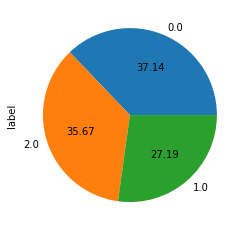

In [ ]:
# nmostra a proporção de labels no resultado final total
reduced_df['label'].value_counts().plot.pie(autopct='%.2f')

In [ ]:
# transforma a data em time series
reduced_df['date'] = pd.to_datetime(full_df['date'])


In [ ]:
# agrupa o total de labels por dia
reduced_df_grouped = reduced_df.groupby(['label', pd.Grouper(key='date', freq='D')]).count()

In [ ]:
reduced_df_grouped.head(10)

id  content
label date                    
0.0   2022-10-02  179      179
      2022-10-03  239      239
      2022-10-04  381      381
      2022-10-05  325      325
      2022-10-06  401      401
      2022-10-07  403      403
      2022-10-08  333      333
      2022-10-09  357      357
      2022-10-10  354      354
      2022-10-11  380      380

In [ ]:
# faz o pivot transformando as linhas de diferente labels em colunas
reduced_df_grouped = reduced_df_grouped.pivot_table(index='date', columns='label', values='content')

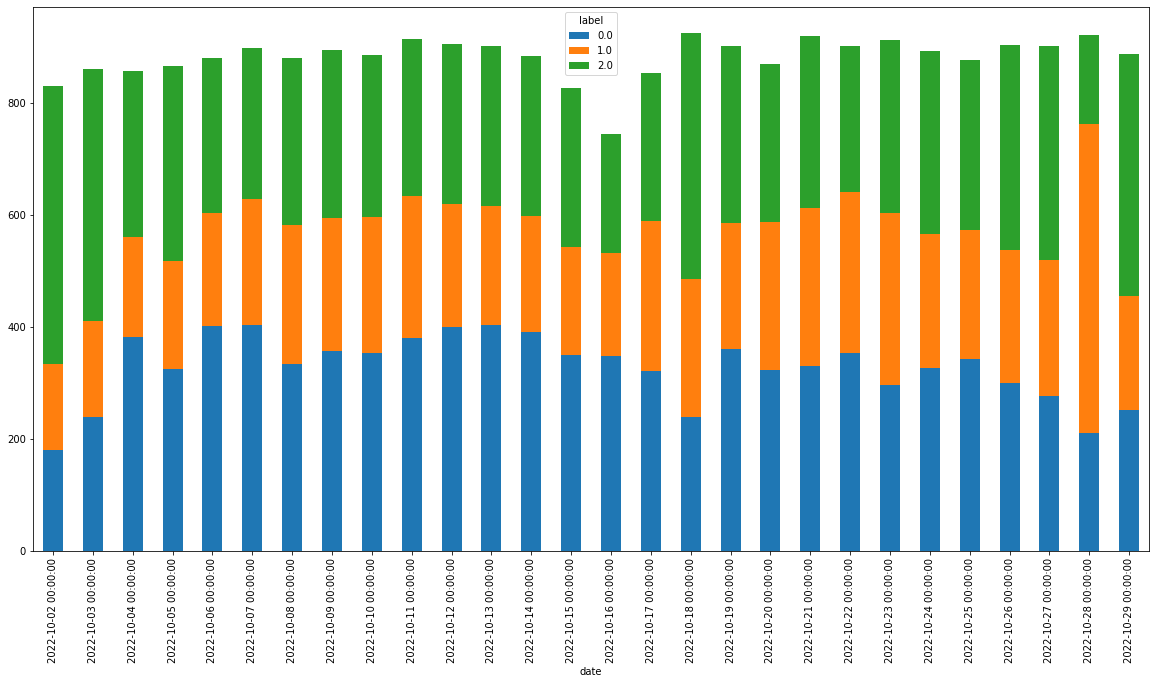

In [ ]:
#plota o gráfico
reduced_df_grouped.plot(kind='bar', stacked=True, figsize=(20,10))

Text(0, 0.5, 'Porcentagem de cada Sentimento')

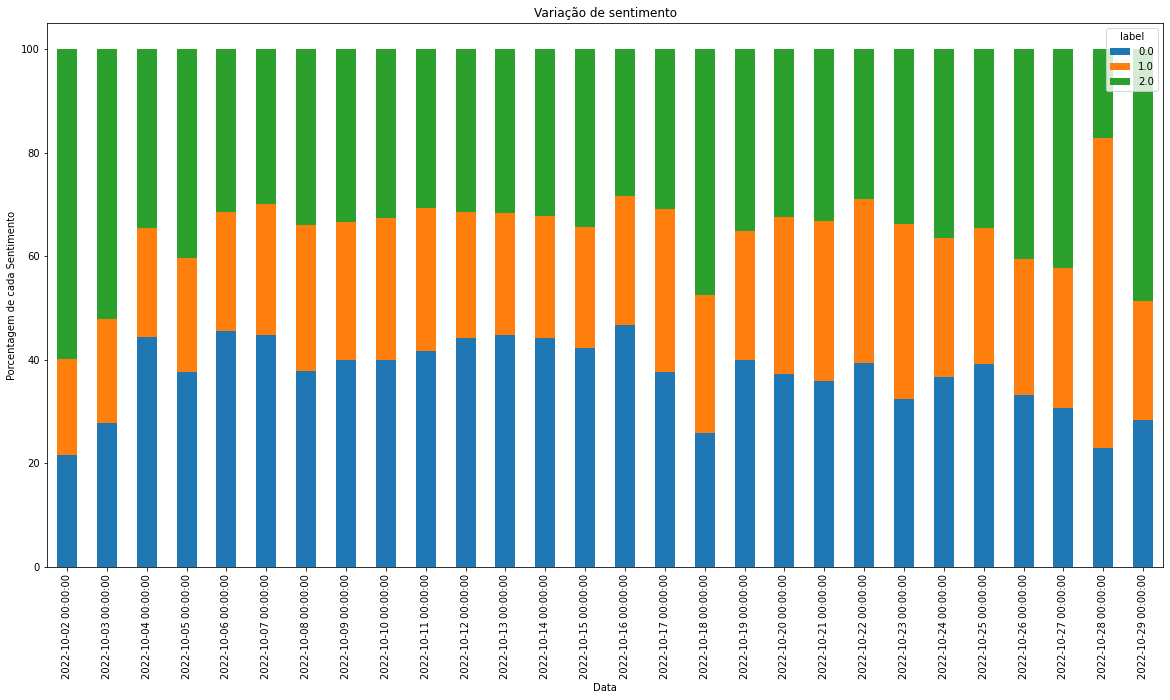

In [ ]:
stacked_data = reduced_df_grouped.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True,  figsize=(20,10))
plt.title("Variação de sentimento")
plt.xlabel("Data")
plt.ylabel("Porcentagem de cada Sentimento")